In [1]:
from urllib.request import urlopen
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Part 1 : Data Loading and Preprocessing

### 1.1. Data Loading

In [3]:
disaster_df = pd.read_csv("/content/drive/Shareddrives/CIS 5450 Project/datasets/DisasterDeclarationsSummaries.csv")
disaster_df.head()

,femaDeclarationString,disasterNumber,state,declarationType,declarationDate,fyDeclared,incidentType,declarationTitle,ihProgramDeclared,iaProgramDeclared,...,tribalRequest,fipsStateCode,fipsCountyCode,placeCode,designatedArea,declarationRequestNumber,lastIAFilingDate,lastRefresh,hash,id
0,FM-5389-AZ,5389,AZ,FM,2021-06-06T00:00:00.000Z,2021,Fire,TELEGRAPH FIRE,0,0,...,0,4,7,99007,Gila (County),21041,NaN,2023-09-29T21:02:14.142Z,14b4a2c314124cae33e8ec790782a12c2af10a4c,226d44a3-418a-4102-9a55-385ea6599b2a
1,FM-5389-AZ,5389,AZ,FM,2021-06-06T00:00:00.000Z,2021,Fire,TELEGRAPH FIRE,0,0,...,0,4,21,99021,Pinal (County),21041,NaN,2023-09-29T21:02:14.142Z,971d2204fdd213515f78a8575ca6fb14e66ca6fb,7304770a-6040-4bb2-b515-a50ffccefa40
2,FM-5464-RI,5464,RI,FM,2023-04-14T00:00:00.000Z,2023,Fire,QUEENS RIVER FIRE,0,0,...,0,44,9,99009,"Washington (County)(in (P)MSA 5520,6480)",23042,NaN,2023-05-22T03:41:22.800Z,1111d4d4a33f8a6e4d383ac5bd0e60b9bf142da0,9b9a9d9c-8b03-4049-9b16-a3c0d581556c
3,FM-5463-KS,5463,KS,FM,2023-04-13T00:00:00.000Z,2023,Fire,HADDAM FIRE,0,0,...,0,20,201,99201,Washington (County),23038,NaN,2023-05-22T03:41:22.800Z,78dd55a181f146622eb65835b5d794689d1ea7f2,57d936ce-a0d7-412a-9d78-18aee530c146
4,FM-5462-NE,5462,NE,FM,2023-04-09T00:00:00.000Z,2023,Fire,WACONDA-BEAVER LAKE FIRE COMPLEX,0,0,...,0,31,25,99025,Cass (County),23036,NaN,2023-05-22T03:41:22.800Z,5b35b5912f606a21ff29194317052ac7c2541be8,69325b2c-77cf-493f-8f1a-d5b5a737edf8


### 1.2. Data Structure Analysis

In [5]:
# check for data types
dtype = disaster_df.dtypes

# check for missing values
isna = disaster_df.isna().sum()

info_df = pd.DataFrame({"dtype": dtype, "isna": isna}).reset_index()
info_df.rename(columns={"index": "column"}, inplace=True)
info_df

,column,dtype,isna
0,femaDeclarationString,object,0
1,disasterNumber,int64,0
2,state,object,0
3,declarationType,object,0
4,declarationDate,object,0
5,fyDeclared,int64,0
6,incidentType,object,0
7,declarationTitle,object,0
8,ihProgramDeclared,int64,0
9,iaProgramDeclared,int64,0


In [6]:
# print only columns with missing values
info_df[info_df["isna"] > 0]

,column,dtype,isna
13,incidentEndDate,object,539
14,disasterCloseoutDate,object,15984
21,lastIAFilingDate,object,46958


### 1.3. Preprocessing

In [7]:
# create fips code column
disaster_df["fipsCode"] = disaster_df["fipsStateCode"].apply(lambda x: str(x).zfill(2)) + disaster_df["fipsCountyCode"].apply(lambda x: str(x).zfill(3))
disaster_df[["fipsCode", "fipsStateCode", "fipsCountyCode"]].head()

,fipsCode,fipsStateCode,fipsCountyCode
0,04007,4,7
1,04021,4,21
2,44009,44,9
3,20201,20,201
4,31025,31,25


In [8]:
# convert to datetime
disaster_df["incidentBeginDate"] = pd.to_datetime(disaster_df["incidentBeginDate"])
disaster_df["incidentEndDate"] = pd.to_datetime(disaster_df["incidentEndDate"])
disaster_df["declarationDate"] = pd.to_datetime(disaster_df["declarationDate"])

# create duration column
disaster_df["incidentDuration"] = disaster_df["incidentEndDate"] - disaster_df["incidentBeginDate"]
disaster_df["incidentDuration"] = disaster_df["incidentDuration"].dt.days

disaster_df[["incidentBeginDate", "incidentEndDate", "incidentDuration"]].head()

,incidentBeginDate,incidentEndDate,incidentDuration
0,2021-06-06 00:00:00+00:00,NaT,NaN
1,2021-06-06 00:00:00+00:00,NaT,NaN
2,2023-04-14 00:00:00+00:00,2023-04-16 00:00:00+00:00,2.0
3,2023-04-13 00:00:00+00:00,2023-04-16 00:00:00+00:00,3.0
4,2023-04-08 00:00:00+00:00,NaT,NaN


## Part 2 : EDA

### 2.1. Number of Incidents by County

In [9]:
# create a new dataframe to count the number of incidents by county
incident_county_df = disaster_df.groupby("fipsCode").count()["id"].reset_index()
incident_county_df.columns = ["county", "numOfIncidents"]
incident_county_df.head()

,county,numOfIncidents
0,01000,11
1,01001,23
2,01003,37
3,01005,27
4,01007,19


In [10]:
# heatmap of number of incidents by county
with urlopen("https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json") as response:
    counties = json.load(response)

fig = px.choropleth(incident_county_df, geojson=counties, locations="county", color="numOfIncidents",
                    color_continuous_scale="deep",
                    range_color=(min(incident_county_df["numOfIncidents"]), 80), # max: more than 80
                    scope="usa",
                    labels={"numOfIncidents":"#incident"})

fig.update_layout(margin={"r":0, "t":0, "l":0, "b":0})
print("< Number of Incidents by County >\n")
fig.show()

Output hidden; open in https://colab.research.google.com to view.

### 2.2 Number of Incidents by Incident Type

In [11]:
# create a new dataframe to count the number of incidents by incident type
incident_type_df = disaster_df.groupby("incidentType").count()["id"].reset_index()
incident_type_df.rename(columns={"id": "numOfIncidents"}, inplace=True)
incident_type_df = incident_type_df.sort_values(by="numOfIncidents", ascending=False).reset_index(drop=True)
incident_type_df.head()

,incidentType,numOfIncidents
0,Severe Storm,17868
1,Hurricane,13204
2,Flood,10871
3,Biological,7857
4,Snowstorm,3707


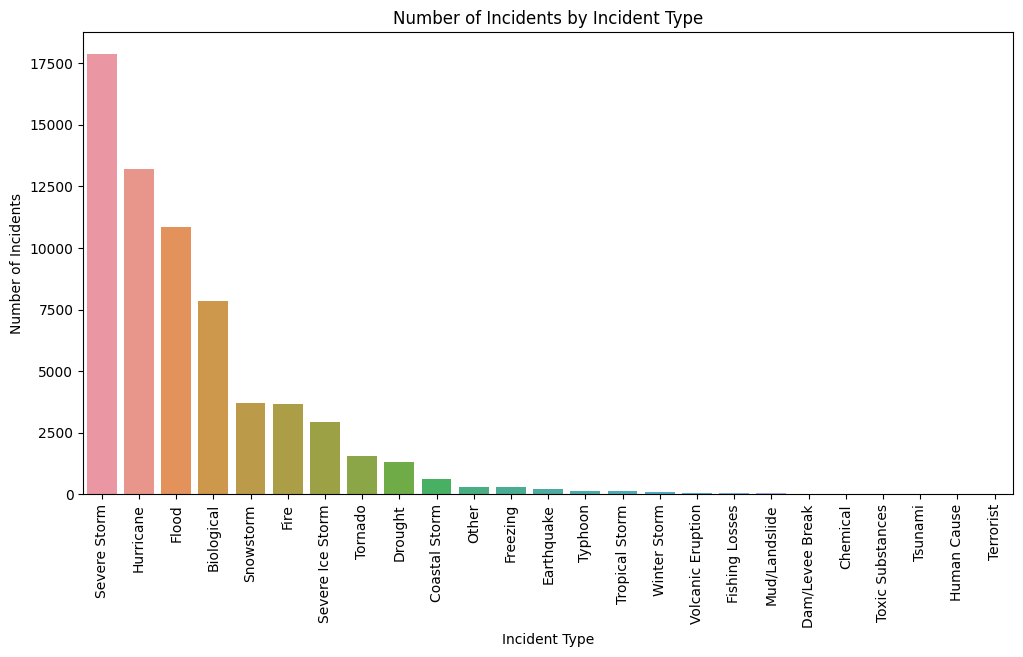

In [12]:
# barplot of number of incidents by incident type
plt.figure(figsize=(12, 6))
sns.barplot(x="incidentType", y="numOfIncidents", data=incident_type_df)
plt.xticks(rotation=90)

plt.title("Number of Incidents by Incident Type")
plt.xlabel("Incident Type")
plt.ylabel("Number of Incidents")
plt.show()

### 2.3. Duration of Incidents by Incident Type

In [13]:
# drop null values in duration column
duration_df = disaster_df.dropna(subset=["incidentDuration"]).reset_index(drop=True)

# create a new dataframe to compute average duration by incident type
duration_df = duration_df.groupby("incidentType").mean(numeric_only=True)["incidentDuration"].reset_index()
duration_df = duration_df.sort_values(by="incidentDuration", ascending=False).reset_index(drop=True)
duration_df.head()

,incidentType,incidentDuration
0,Biological,1207.000000
1,Toxic Substances,117.777778
2,Volcanic Eruption,106.372549
3,Fishing Losses,78.428571
4,Fire,66.354233


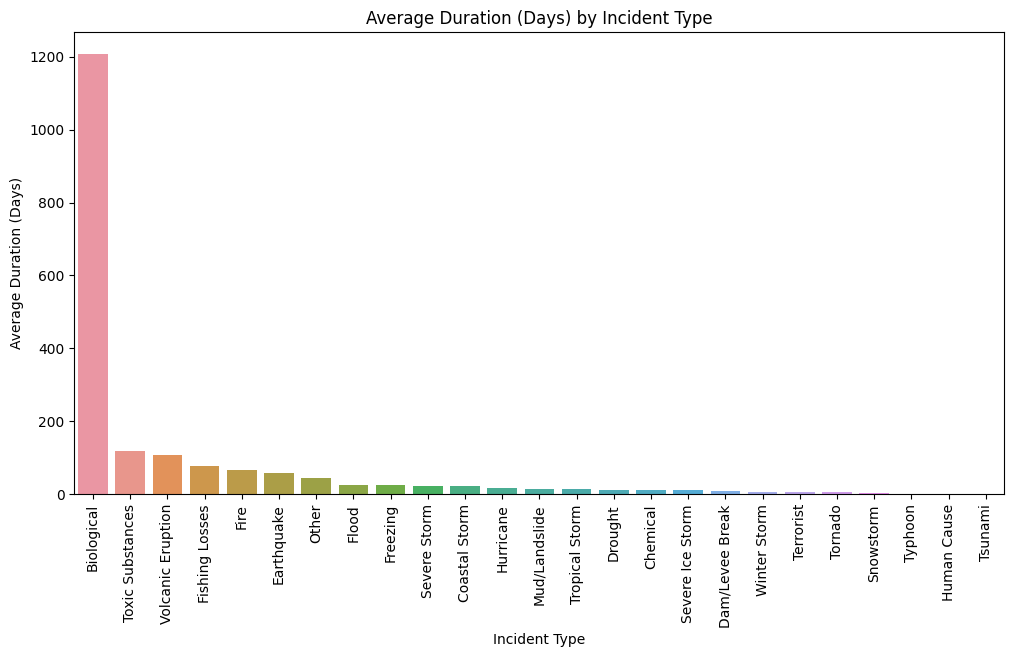

In [14]:
# barplot of average duration by incident type
plt.figure(figsize=(12, 6))
sns.barplot(x="incidentType", y="incidentDuration", data=duration_df)
plt.xticks(rotation=90)

plt.title("Average Duration (Days) by Incident Type")
plt.xlabel("Incident Type")
plt.ylabel("Average Duration (Days)")
plt.show()

In [ ]:
# check declarelation title for biological incidents
disaster_df[disaster_df["incidentType"] == "Biological"]["declarationTitle"].unique()

array(['COVID-19 PANDEMIC', 'COVID-19', 'COVID-19 '], dtype=object)

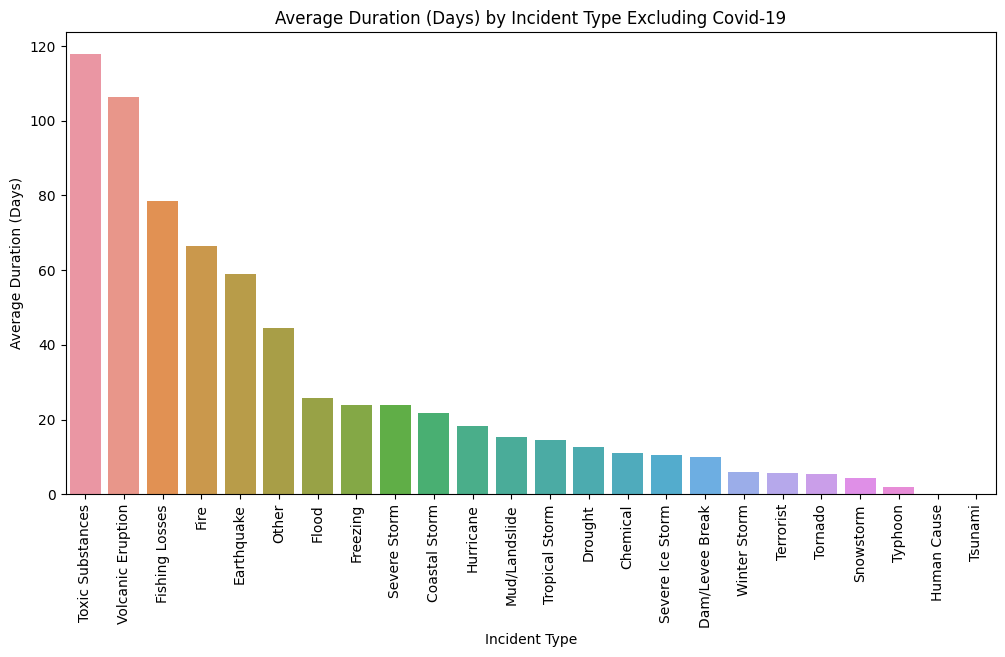

In [15]:
# barplot of average duration by incident type excluding Covid-19
plt.figure(figsize=(12, 6))
sns.barplot(x="incidentType", y="incidentDuration", data=duration_df[duration_df["incidentType"] != "Biological"])
plt.xticks(rotation=90)

plt.title("Average Duration (Days) by Incident Type Excluding Covid-19")
plt.xlabel("Incident Type")
plt.ylabel("Average Duration (Days)")
plt.show()

### 2.4. Number of Incidents by Year

In [16]:
# create a new dataframe to count the number of incidents by year
declaration_df = disaster_df.copy()
declaration_df["declarationYear"] = declaration_df["declarationDate"].dt.year

declaration_total_df = declaration_df.groupby("declarationYear").count()["id"].reset_index()
declaration_total_df.rename(columns={"id": "numOfIncidents"}, inplace=True)
declaration_total_df.head()

,declarationYear,numOfIncidents
0,1953,13
1,1954,17
2,1955,18
3,1956,16
4,1957,16


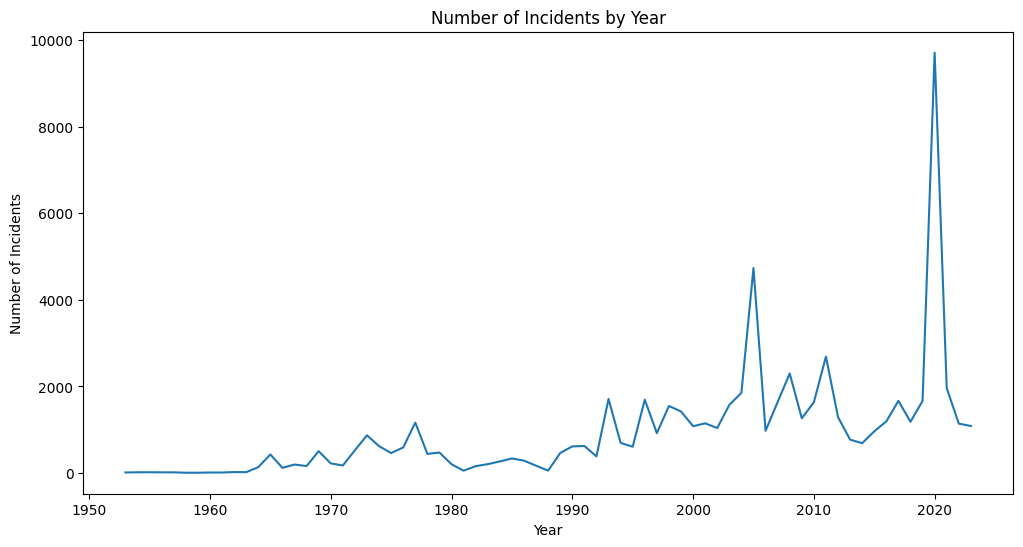

In [17]:
# lineplot of number of incidents by year
plt.figure(figsize=(12, 6))
sns.lineplot(x="declarationYear", y="numOfIncidents", data=declaration_total_df)

plt.title("Number of Incidents by Year")
plt.xlabel("Year")
plt.ylabel("Number of Incidents")
plt.show()

In [18]:
# create a new dataframe to count the number of top 5 incidents by year
top_incidents = incident_type_df["incidentType"][:5].to_list()
declaration_type_df = declaration_df[declaration_df["incidentType"].isin(top_incidents)]

declaration_type_df = declaration_type_df.groupby(["declarationYear", "incidentType"]).count()["id"].reset_index()
declaration_type_df.rename(columns={"id": "numOfIncidents"}, inplace=True)
declaration_type_df.head()

,declarationYear,incidentType,numOfIncidents
0,1953,Flood,5
1,1954,Flood,7
2,1954,Hurricane,7
3,1955,Flood,8
4,1955,Hurricane,7


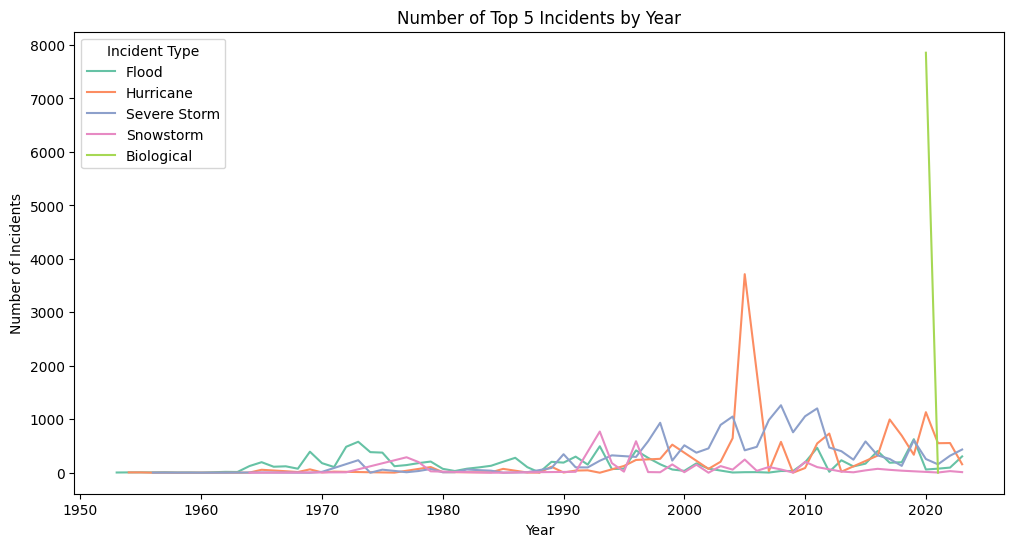

In [19]:
# lineplot of number of top 5 incidents by year
plt.figure(figsize=(12, 6))
sns.set_palette("Set2")
sns.lineplot(x="declarationYear", y="numOfIncidents", hue="incidentType", data=declaration_type_df)

plt.title("Number of Top 5 Incidents by Year")
plt.xlabel("Year")
plt.ylabel("Number of Incidents")
plt.legend(title="Incident Type")
plt.show()

In [20]:
# create a new dataframe to count the number of top 5 incidents by year excluding Covid-19
top_incidents2 = incident_type_df[incident_type_df['incidentType'] != "Biological"]["incidentType"][:5].to_list()
declaration_type_df2 = declaration_df[declaration_df["incidentType"].isin(top_incidents2)]

declaration_type_df2 = declaration_type_df2.groupby(["declarationYear", "incidentType"]).count()["id"].reset_index()
declaration_type_df2.rename(columns={"id": "numOfIncidents"}, inplace=True)
declaration_type_df2.head()

,declarationYear,incidentType,numOfIncidents
0,1953,Fire,1
1,1953,Flood,5
2,1954,Flood,7
3,1954,Hurricane,7
4,1955,Flood,8


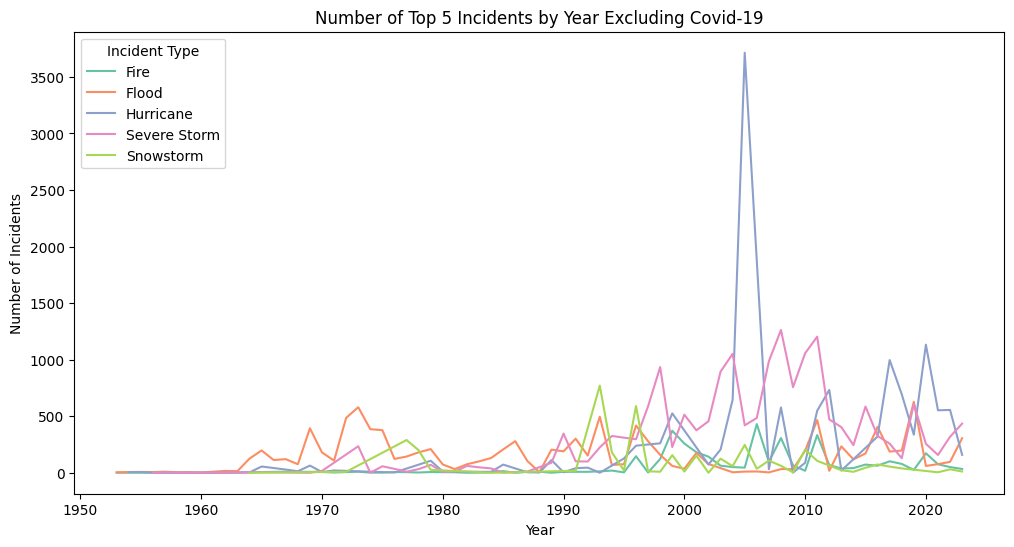

In [21]:
# lineplot of number of top 5 incidents by year excluding Covid-19
plt.figure(figsize=(12, 6))
sns.set_palette("Set2")
sns.lineplot(x="declarationYear", y="numOfIncidents", hue="incidentType", data=declaration_type_df2)

plt.title("Number of Top 5 Incidents by Year Excluding Covid-19")
plt.xlabel("Year")
plt.ylabel("Number of Incidents")
plt.legend(title="Incident Type", loc="upper left")
plt.show()